hacemos una lista de nuestros sets

In [1]:
sets = !ls NGC6426_* -d
sets

['NGC6426_2407_I',
 'NGC6426_2407_V',
 'NGC6426_2505_I',
 'NGC6426_2505_V',
 'NGC6426_2506A_I',
 'NGC6426_2506A_V',
 'NGC6426_2506B_I',
 'NGC6426_2506B_V',
 'NGC6426_2508_I',
 'NGC6426_2508_V']

obtenemos una lista de los ids del catalogo de coordenadas `coordinates_NGC6426.dat` que nos pasó Raul y lo guardamos en `todas`

In [2]:
todas = !awk '{print $1}' NGC6426/coordinates_NGC6426.dat
print(len(todas))

todas[:5]

1373


['6', '7', '8', '9', '10']

### definimos la funcion que mas tarde vamos a iterar: `flux_to_magnitudes` sobre cada lc individual

In [3]:
from to_magnitudes import get_physical_by_id, get_m_ref_new, isis_flux_to_mag_new
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def flux_to_magnitudes(set_name, star_id, reference_fit, star_lc, physical_coords_file): 
    # leer archivo con pandas (más robusto que np.loadtxt)
    df = pd.read_csv(star_lc, delim_whitespace=True, header=None)

    # delta_flux está en la columna 1 (segunda columna)
    delta_flux = df[1].to_numpy(dtype=float)
    
    # coordenadas físicas
    x_physical, y_physical = get_physical_by_id(physical_coords_file, star_id)
    
    # magnitud de referencia
    ref_list = pd.read_csv(f'{set_name}/ref_list', delim_whitespace=True, header=None)
    hjd_bjd_exptime = pd.read_csv(f'{set_name}/hjd_bjd_exptime', delim_whitespace=True, header=None)
    ref_metadata = hjd_bjd_exptime[hjd_bjd_exptime[0].isin(ref_list[0])]
    # tratamos el exptime de ref.fits como la suma de sus exptimes ?????
    ref_exptime = np.sum(ref_metadata[4])
    
    m_ref, flux_ref = get_m_ref_new(reference_fit, x_physical, y_physical, 
                                aperture_radius=7.0, exptime=ref_exptime)
    #print(f"m_ref = {m_ref:.3f} (flux = {flux_ref:.1f})")
    
    
    # renombramos para claridad
    df = df.rename(columns={0: "hjd"})
    hjd_bjd_exptime = hjd_bjd_exptime.rename(columns={0: "file", 2: "hjd", 3: "bjd", 4: "exptime"})

    # merge SOLO para agregar 'file'
    df = pd.merge_asof(
        df, 
        hjd_bjd_exptime[["file", "hjd", "exptime", "bjd"]],
        on="hjd",
        direction="nearest",
        tolerance=1e-6   # aquí ajustas según el error máximo permitido
    ).set_index("file")

    df = df.rename(columns={"hjd": 0})

    
    
    # conversión a magnitudes instrumentales
    mag_instr = isis_flux_to_mag_new(df[1], m_ref, df['exptime'])
    
    # agregar magnitud como nueva columna
    df['mag'] = mag_instr
    
    # guardar en mismo set
    output_path = f'{set_name}/lcs/lc{set_name[8:]}_{star_id}_mag.data'
    df.to_csv(output_path, sep="\t", index=False, header=False)
    #print(f"✅ Guardado: {output_path}")
    return df

### Iteramos sobre cada lc

In [4]:
import logging
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="astropy")

# configurar log (solo a archivo, no en pantalla)
logging.basicConfig(
    filename="NGC6426/errores.log",
    filemode="a",
    level=logging.ERROR,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

total = len(sets) * len(todas)
procesados = 0
errores = Counter()

for set in sets: 
    for star_id in todas: 
        set_id = set[8:]
        reference_fit = f'{set}/ref.fits'
        star_lc = f'{set}/lcs/lc{star_id}.data'
        physical_coords_file = f'{set}/phot_{set_id}.data'

        try:
            #print('procesando ', star_lc)
            np.seterr(invalid="ignore", divide="ignore")
            flux_to_magnitudes(
                set_name=set,
                star_id=star_id,
                reference_fit=reference_fit,
                star_lc=star_lc,
                physical_coords_file=physical_coords_file
            )
        except FileNotFoundError:
            errores["FileNotFound"] += 1
            #logging.error(f"{star_lc} no existe")
        except Exception as e:
            errores["Otros"] += 1
            logging.error(f"Error procesando {star_lc}: {e}")
        finally:
            procesados += 1
            if procesados % 20 == 0:  # actualiza cada 20 procesos
                pct = (procesados / total) * 100
                print(f"[{pct:.1f}%] Procesados: {procesados}/{total} | "
                      f"Errores: {sum(errores.values())} "
                      f"(FileNotFound={errores['FileNotFound']}, Otros={errores['Otros']})")

[0.1%] Procesados: 20/13730 | Errores: 8 (FileNotFound=8, Otros=0)
[0.3%] Procesados: 40/13730 | Errores: 9 (FileNotFound=9, Otros=0)
[0.4%] Procesados: 60/13730 | Errores: 10 (FileNotFound=10, Otros=0)
[0.6%] Procesados: 80/13730 | Errores: 10 (FileNotFound=10, Otros=0)
[0.7%] Procesados: 100/13730 | Errores: 11 (FileNotFound=11, Otros=0)
[0.9%] Procesados: 120/13730 | Errores: 12 (FileNotFound=12, Otros=0)
[1.0%] Procesados: 140/13730 | Errores: 13 (FileNotFound=13, Otros=0)
[1.2%] Procesados: 160/13730 | Errores: 13 (FileNotFound=13, Otros=0)
[1.3%] Procesados: 180/13730 | Errores: 13 (FileNotFound=13, Otros=0)
[1.5%] Procesados: 200/13730 | Errores: 14 (FileNotFound=14, Otros=0)
[1.6%] Procesados: 220/13730 | Errores: 14 (FileNotFound=14, Otros=0)
[1.7%] Procesados: 240/13730 | Errores: 17 (FileNotFound=17, Otros=0)
[1.9%] Procesados: 260/13730 | Errores: 19 (FileNotFound=19, Otros=0)
[2.0%] Procesados: 280/13730 | Errores: 20 (FileNotFound=20, Otros=0)
[2.2%] Procesados: 300/13730

### Ejecutamos el script `./carpeta_por_id.sh`. 

Esto crea los directorios 

`NGC6426/lcs/V/` 

y 

`NGC6426/lcs/I/`, 

ademas de una carpeta para cada `id` donde copia todas las curvas de luz de la misma estrella y filtro a través de los distintos sets.

In [5]:
I_list = !ls NGC6426/lcs/I 
V_list = !ls NGC6426/lcs/V

len(V_list)

1373

### Concatenamos 
todas las curvas de luz de la misma estrella de acuerdo a su directorio dentro de `NGC6426/lcs/<filtro>/<id>`

Los resultados se guardan en los directorios 

`NGC6426/lcs/V_full` 

y 

`NGC6426/lcs/I_full`

In [8]:
import pandas as pd
!mkdir NGC6426/lcs/V_full/
i = 0 
for lc in V_list: 
    i = i+1
    to_merge = !ls NGC6426/lcs/V/{lc}/*
    #combina todos los archivos de la lista
    combinado_csv = pd.concat([pd.read_csv(f, delim_whitespace=True, header=None) for f in to_merge])
    #exporta a csv
    combinado_csv.to_csv(f"NGC6426/lcs/V_full/lc{lc}_V.data", sep="\t", index=False, header=False)
    print(i, '/', len(V_list))

1 / 1373
2 / 1373
3 / 1373
4 / 1373
5 / 1373
6 / 1373
7 / 1373
8 / 1373
9 / 1373
10 / 1373
11 / 1373
12 / 1373
13 / 1373
14 / 1373
15 / 1373
16 / 1373
17 / 1373
18 / 1373
19 / 1373
20 / 1373
21 / 1373
22 / 1373
23 / 1373
24 / 1373
25 / 1373
26 / 1373
27 / 1373
28 / 1373
29 / 1373
30 / 1373
31 / 1373
32 / 1373
33 / 1373
34 / 1373
35 / 1373
36 / 1373
37 / 1373
38 / 1373
39 / 1373
40 / 1373
41 / 1373
42 / 1373
43 / 1373
44 / 1373
45 / 1373
46 / 1373
47 / 1373
48 / 1373
49 / 1373
50 / 1373
51 / 1373
52 / 1373
53 / 1373
54 / 1373
55 / 1373
56 / 1373
57 / 1373
58 / 1373
59 / 1373
60 / 1373
61 / 1373
62 / 1373
63 / 1373
64 / 1373
65 / 1373
66 / 1373
67 / 1373
68 / 1373
69 / 1373
70 / 1373
71 / 1373
72 / 1373
73 / 1373
74 / 1373
75 / 1373
76 / 1373
77 / 1373
78 / 1373
79 / 1373
80 / 1373
81 / 1373
82 / 1373
83 / 1373
84 / 1373
85 / 1373
86 / 1373
87 / 1373
88 / 1373
89 / 1373
90 / 1373
91 / 1373
92 / 1373
93 / 1373
94 / 1373
95 / 1373
96 / 1373
97 / 1373
98 / 1373
99 / 1373
100 / 1373
101 / 13

In [9]:
!mkdir NGC6426/lcs/I_full/
i = 0 
for lc in I_list: 
    i = i+1
    to_merge = !ls NGC6426/lcs/I/{lc}/*
    #combina todos los archivos de la lista
    combinado_csv = pd.concat([pd.read_csv(f, delim_whitespace=True, header=None) for f in to_merge])
    #exporta a csv
    combinado_csv.to_csv(f"NGC6426/lcs/I_full/lc{lc}_I.data", sep="\t", index=False, header=False)
    print(i, '/', len(I_list))

1 / 1373
2 / 1373
3 / 1373
4 / 1373
5 / 1373
6 / 1373
7 / 1373
8 / 1373
9 / 1373
10 / 1373
11 / 1373
12 / 1373
13 / 1373
14 / 1373
15 / 1373
16 / 1373
17 / 1373
18 / 1373
19 / 1373
20 / 1373
21 / 1373
22 / 1373
23 / 1373
24 / 1373
25 / 1373
26 / 1373
27 / 1373
28 / 1373
29 / 1373
30 / 1373
31 / 1373
32 / 1373
33 / 1373
34 / 1373
35 / 1373
36 / 1373
37 / 1373
38 / 1373
39 / 1373
40 / 1373
41 / 1373
42 / 1373
43 / 1373
44 / 1373
45 / 1373
46 / 1373
47 / 1373
48 / 1373
49 / 1373
50 / 1373
51 / 1373
52 / 1373
53 / 1373
54 / 1373
55 / 1373
56 / 1373
57 / 1373
58 / 1373
59 / 1373
60 / 1373
61 / 1373
62 / 1373
63 / 1373
64 / 1373
65 / 1373
66 / 1373
67 / 1373
68 / 1373
69 / 1373
70 / 1373
71 / 1373
72 / 1373
73 / 1373
74 / 1373
75 / 1373
76 / 1373
77 / 1373
78 / 1373
79 / 1373
80 / 1373
81 / 1373
82 / 1373
83 / 1373
84 / 1373
85 / 1373
86 / 1373
87 / 1373
88 / 1373
89 / 1373
90 / 1373
91 / 1373
92 / 1373
93 / 1373
94 / 1373
95 / 1373
96 / 1373
97 / 1373
98 / 1373
99 / 1373
100 / 1373
101 / 13

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# parámetros
hjd0 = 2460000.0
period = 0.617861  # cámbialo por tu valor
#period = 0.681990

# cargar datos
star_id = '265'
#star_id = '688'

star_lc_V_path = f'NGC6426/lcs/V_full/lc{star_id}_V.data'
star_lc_I_path = f'NGC6426/lcs/I_full/lc{star_id}_I.data'

star_lc_V = np.loadtxt(star_lc_V_path, unpack=True)
star_lc_I = np.loadtxt(star_lc_I_path, unpack=True)

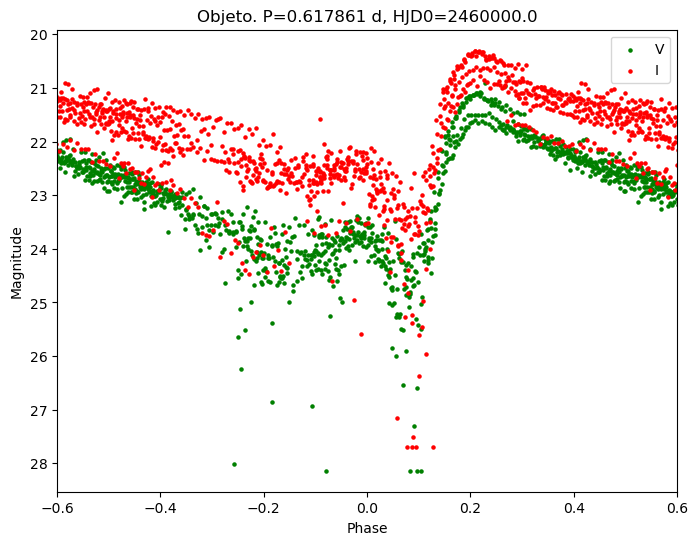

In [13]:
from lightcurve_plots import raul_plot, raul_plot_byxy

raul_plot(star_lc_V_path, star_lc_I_path, period, hjd0 = 2460000.0)

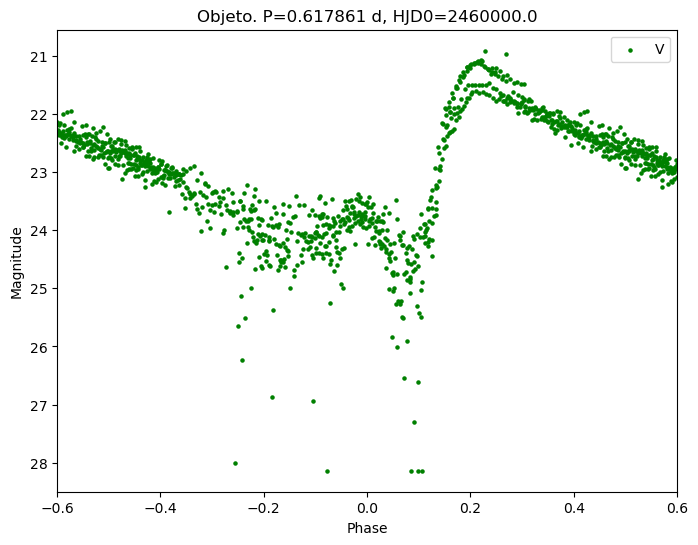

In [16]:
x, y = star_lc_V[-2], star_lc_V[-1]
raul_plot_byxy(x, y, period, hjd0 = 2460000.0)

In [17]:
pd.read_csv(star_lc_V_path, delim_whitespace=True, header=None)

,0,1,2,3,4,5,6,7,8
0,2.460509e+06,-3369.1264,213.8320,-3467.2180,214.2875,0.7569,100.0,2.460509e+06,20.968324
1,2.460509e+06,-2878.2993,266.9607,-2967.5606,267.5615,0.7916,180.0,2.460509e+06,21.744984
2,2.460509e+06,-3314.9555,244.3059,-3369.6682,244.9955,0.8556,180.0,2.460509e+06,21.620950
3,2.460509e+06,-2592.5607,236.7633,-2679.8777,237.5826,0.8164,180.0,2.460509e+06,21.834564
4,2.460509e+06,-2689.7059,219.5310,-2805.2655,220.7133,0.8153,180.0,2.460509e+06,21.803272
...,...,...,...,...,...,...,...,...,...
919,2.460905e+06,-2943.0773,112.1358,-3467.0760,127.6767,0.8582,180.0,2.460905e+06,21.316894
920,2.460905e+06,-2984.5809,115.0522,-3463.0574,128.5417,0.8641,180.0,2.460905e+06,21.308507
921,2.460905e+06,-2834.9412,111.9971,-3290.7315,126.2530,0.8835,180.0,2.460905e+06,21.339056
922,2.460905e+06,-2546.2074,109.4210,-3092.3484,125.3151,0.8549,180.0,2.460905e+06,21.400547
